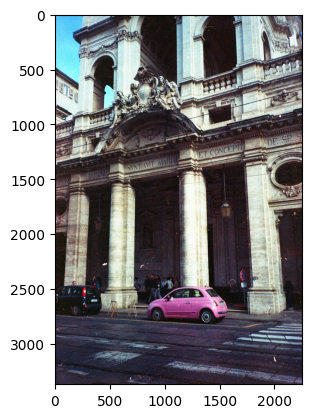

In [168]:
from skimage import segmentation, morphology
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy import ndimage
from skimage.io import imread
from skimage.color import rgb2lab
from skimage.color import lab2rgb
from skimage.color import label2rgb
from skimage.transform import resize
from PIL import Image

# Load the image
image = imread('test.jpg')
# image = imread('bus.png')

# show image
import matplotlib.pyplot as plt

plt.imshow(image)

In [169]:
maxInt = image.max()
minInt = image.min()
print(maxInt)
print(minInt)

255
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


512 342
SLIC number of segments: 23
SLIC segments shape: (512, 342)


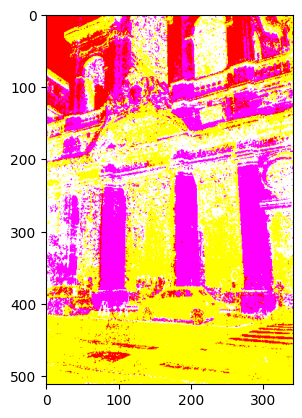

In [199]:
# let us first resize image to prevent memory issues
MAX_EDGE_LENGTH = 512
height = image.shape[0]
width = image.shape[1]
width_height_ratio = height / width

is_width_longer = width > height
should_resize = height > MAX_EDGE_LENGTH or width > MAX_EDGE_LENGTH

resized_image = None

resize_ratio = 1

newWidth = width
newHeight = height

if should_resize:
    print('Resizing image')
    if is_width_longer:
        newWidth = 512
        newHeight = 512 * width_height_ratio
    else:
        newHeight = 512
        newWidth = 512 / width_height_ratio


image = resize(image, (newHeight, newWidth))

print(newHeight, newWidth)

# if 4 channels, remove the alpha channel
if image.shape[2] == 4:
    image = image[:, :, :3]
# image = resize(image, (256, 256))

# Convert the image to Lab color space
lab_image = rgb2lab(image)

# plot lab image

plt.imshow(lab_image)

# Step 1: Apply SLIC algorithm to create superpixels
# n_segments: number of segments (= the desired number of superpixels) -> Superpixel: a group of connected pixels that share similar color
# More superpixels -> more segments -> more detailed segmentation
# compactness: balance between color proximity and space proximity
# sigma: width of Gaussian smoothing kernel
segments_slic = segmentation.slic(lab_image, n_segments=30, compactness=20, sigma=0.5) # each pixel is assigned to the superpixel it belongs to (numbered from 1 to n_segments)

print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))

print('SLIC segments shape: {}'.format(segments_slic.shape))

# plt.imshow(label2rgb(segments_slic, image))


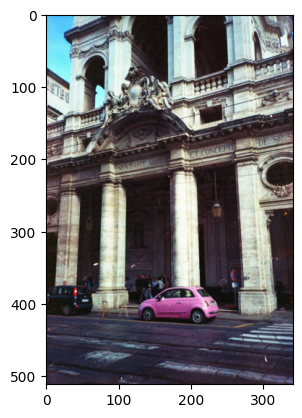

In [200]:
lab_to_rgb = lab2rgb(lab_image)

plt.imshow(lab_to_rgb)

In [220]:
from scipy import stats

test_mode = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3]])
print(stats.mode(test_mode, axis=0).mode)


[1 2 3]


In [235]:



dominant_colors = []

i = 0
for segment_label in np.unique(segments_slic):
    mask = segments_slic == segment_label
    print(lab_image.shape)
    segment_colors = lab_image[mask]
    
    # Find the most frequent color (mode) in the superpixel
    # Mode works on the flattened array, so we reshape to (-1, 3) assuming segment_colors is 3-channel
    print(segment_colors.shape)
    mode_result = stats.mode(segment_colors, axis=0)
    dominant_color_lab = mode_result.mode  # Most frequent color in LAB
    # print('Dominant color in segment {}: {}'.format(i, dominant_color_lab))
    print(dominant_color_lab)
    # dominant_color_lab = dominant_color_lab.reshape(1, 1, 3)  # Reshape for conversion function
    
    # Convert the dominant LAB color to RGB
    dominant_color_rgb = lab2rgb(dominant_color_lab)
    
    # Append the RGB color, scaled to 0-255 range for display
    print('Dominant color in segment {}: {}'.format(i, dominant_color_rgb))
    dominant_colors.append((dominant_color_rgb))

(512, 342, 3)
(17937, 3)
[  4.895637   -34.46267422 -51.91346144]
Dominant color in segment 0: [0.         0.13899734 0.34337224]
(512, 342, 3)
(4541, 3)
[  3.18011623 -11.69822387 -27.93760007]
Dominant color in segment 0: [0.         0.08169724 0.19636441]
(512, 342, 3)
(9932, 3)
[  4.19829681 -17.89553176 -22.20311235]
Dominant color in segment 0: [0.         0.09803573 0.17463053]
(512, 342, 3)
(3766, 3)
[  3.43032106  -9.54995911 -26.74995751]
Dominant color in segment 0: [0.         0.07943521 0.19234804]
(512, 342, 3)
(5765, 3)
[ 12.07376394 -15.03457518 -52.59414585]
Dominant color in segment 0: [0.         0.16665031 0.41803866]
(512, 342, 3)
(5927, 3)
[  5.02675684 -12.54349653 -20.20757295]
Dominant color in segment 0: [0.         0.09523372 0.17142401]
(512, 342, 3)
(17223, 3)
[  4.50701392 -13.30196999 -20.59575188]
Dominant color in segment 0: [0.         0.09252645 0.16907164]
(512, 342, 3)
(7438, 3)
[  4.92500087 -10.42001407 -15.90966977]
Dominant color in segment 0: [

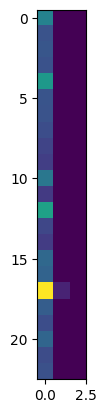

In [240]:
# plot the dominant colors
dominant_colors = np.array(dominant_colors)


plt.imshow(dominant_colors)

In [237]:
max_int = np.max(dominant_colors)
min_int = np.min(dominant_colors)
print('max_int: {}'.format(max_int))
print('min_int: {}'.format(min_int))

max_int: 0.41803865641770416
min_int: 0.0


(512, 342, 3)
(512, 342, 3)


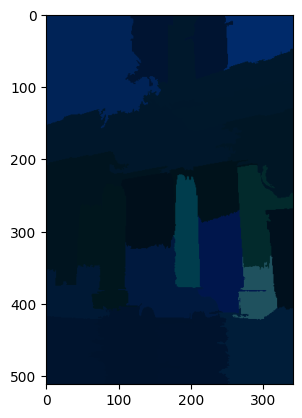

In [238]:

output_image = np.zeros_like(image)
print(output_image.shape)

for segment_label, color in zip(np.unique(segments_slic), dominant_colors):
    # print('segment_label: {}, color: {}'.format(segment_label, color))
    output_image[segments_slic == segment_label] = color

# change bgr to rgb

plt.imshow(output_image)

print(output_image.shape)

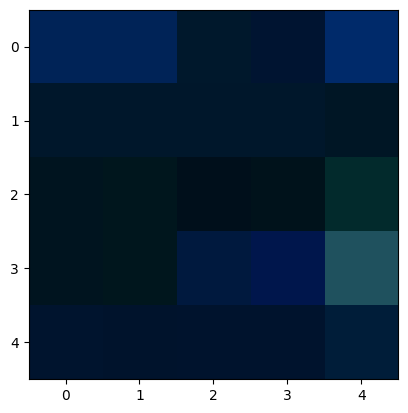

In [219]:

# Step 5: Downsample and upsample the image
# For this example, we'll simply blur and then resize
scale_down_factor = 0.001
# we downsample the image by a factor of 2 (half the size)
# downsize to 5 X 5

downsampled = resize(output_image, (5,5), anti_aliasing=False)
upsampled = resize(downsampled, output_image.shape, anti_aliasing=False, order=0)

# Display the upsampled image or process it further as needed
plt.imshow(downsampled)



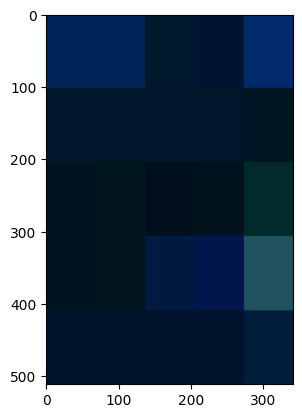

In [206]:
plt.imshow(upsampled)

In [152]:

# Step 5: Downsample and upsample the image
# For this example, we'll simply blur and then resize
scale_down_factor = 0.001
# we downsample the image by a factor of 2 (half the size)
# downsize to 5 X 5

downsampled = resize(out, (5,5), anti_aliasing=False)
# upsampled = resize(downsampled, out.shape, anti_aliasing=True)

# Display the upsampled image or process it further as needed
plt.imshow(downsampled)


NameError: name 'out' is not defined

In [145]:
print(upsampled.shape)

(3368, 2248, 3)


In [144]:
# To get square blocks, you can apply a dilation with a square structure element if needed
selem = morphology.square(5)  # Adjust the size of the square as needed
upsampled_blocks = morphology.dilation(upsampled, selem)

print(selem)
print('upsampled_blocks shape: {}'.format(upsampled_blocks.shape))

IndexError: tuple index out of range

In [120]:
# Step 4: Assign the superpixel the color
palette = lab2rgb(dominant_colors[:, np.newaxis, :])
output_image = np.zeros_like(image)

for segment_id, color in zip(segment_ids, palette):
    mask = segments_slic == segment_id
    output_image[mask] = (color * 255).astype(np.uint8)

print(output_image.shape)

(3368, 2248, 3)


In [121]:

# Step 5: Downsample and upsample the image
# For this example, we'll simply blur and then resize
scale_down_factor = 0.1
# we downsample the image by a factor of 2 (half the size)
downsampled = resize(output_image, (int(output_image.shape[0] * scale_down_factor), int(output_image.shape[1] * scale_down_factor)), anti_aliasing=True)
upsampled = resize(downsampled, output_image.shape, anti_aliasing=True)

# Display the upsampled image or process it further as needed

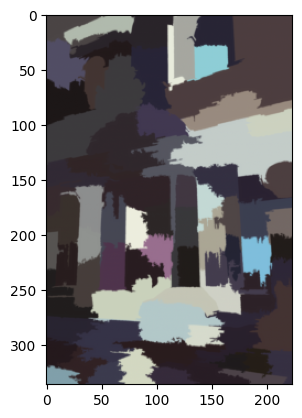

In [122]:
plt.imshow(downsampled)

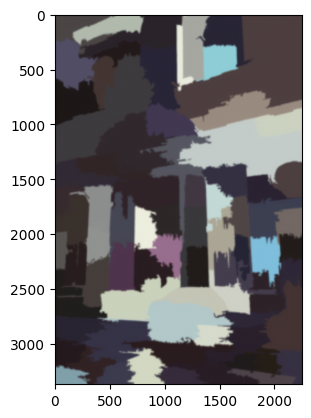

In [123]:
# plot upsamled image
plt.imshow(upsampled)